In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.fed_batch_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

STEP = 20
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR01'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
def plot_feed(feeds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], align='edge')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Feed (mL/h)')
    ax.set_title('Feed vs Time')
    plt.show()
    
def plot_simulation(t=None, y=None, feeds: Optional[pd.DataFrame] = None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None, save: Optional[bool] = False):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    if t is not None and y is not None:
        ax1.plot(t, y[0], label='Biomass (ODE)', alpha=0.6)
        ax1.plot(t, y[1], label='Glucose (ODE)', alpha=0.6)
    
    if full_df is not None:
        ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='red', alpha=0.2)   
        ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='green', alpha=0.2)
    
    if train_df is not None:
        ax1.scatter(train_df['RTime'], train_df['Glucose'], label='_Glucose (Train)', color='red', alpha=1)   
        ax1.scatter(train_df['RTime'], train_df['Biomass'], label='_Biomass (Train)', color='green', alpha=1)
    
    if net_df is not None:

        # Check if len(net_df) == len(full_df); If yes->scatter, else->plot
        if len(net_df) == len(full_df):
            ax1.scatter(net_df['RTime'], net_df['Glucose'], label='Glucose (PINN)', marker='x', color='red', alpha=0.5)
            ax1.scatter(net_df['RTime'], net_df['Biomass'], label='Biomass (PINN)', marker='x', color='green', alpha=0.5)
        else:
            ax1.plot(net_df['RTime'], net_df['Glucose'], label='Glucose (PINN)', color='red', alpha=0.5)
            ax1.plot(net_df['RTime'], net_df['Biomass'], label='Biomass (PINN)', color='green', alpha=0.5)

    plt.xlabel("Time (hours)")
    plt.ylabel("Concentration")
    plt.title(title)
    
    if feeds is not None:
        ax2 = ax1.twinx()
        ax2.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], \
            align='edge', label='Feed', alpha=0.5, color=None, \
            edgecolor='black', linewidth=1, fill=False)
        ax2.set_ylabel('Feed Rate')
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    if feeds is not None:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        ax2.legend(handles, labels, loc='upper left')
    else:
        ax1.legend(handles1, labels1, loc='upper left')

    if save:
        plt.savefig(f'../plots/new_fed_batch_{len(train_df)}.png')
    plt.show()
 
def get_feed(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(df: pd.DataFrame, feeds: pd.DataFrame, mu_max, Ks, Yxs, plot: bool = True):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    Sin = 1.43 * 200

    def system_ode(t, y):
        X, S, V = y
        mu = mu_max * S / (Ks + S)
        F = get_feed(feeds, t)
        dXdt = mu * X - F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dVdt = F
        return [dXdt, dSdt, dVdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], df['V'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    # Transform negative values to 0
    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    if plot:
        plot_simulation(sol.t, sol.y, feeds=feeds, full_df=df)

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame, method: str = 'validation'):
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    # If method == 'validation', we use the real time values
    if method == 'validation':
        t_test = df['RTime'].values
        net_df['RTime'] = t_test
    elif method == 'full':
        t_test = np.linspace(df['RTime'].min(), df['RTime'].max(), 1000)
        net_df["RTime"] = t_test

    t_test = numpy_to_tensor(t_test)
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df

def fit_polynomial(full_df: pd.DataFrame, degree: int = 4, step: int = STEP, plot: bool =True):
    poly = PolynomialFeatures(degree=4)
    t_train = poly.fit_transform(full_df['RTime'].values.reshape(-1, 1))
    y_train = full_df[['Biomass', 'Glucose', 'V']].values
    reg = LinearRegression().fit(t_train, y_train)

    t_sim = poly.fit_transform(np.linspace(full_df['RTime'].min(), full_df['RTime'].max(), STEP).reshape(-1, 1))
    y_sim = reg.predict(t_sim)

    df_sim = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose', 'V'])
    df_sim['RTime'] = np.linspace(full_df['RTime'].min(), full_df['RTime'].max(), STEP) 
    df_sim['Biomass'] = y_sim[:, 0]
    df_sim['Glucose'] = y_sim[:, 1]
    df_sim['V'] = y_sim[:, 2]
    df_sim.loc[df_sim['Glucose'] < 0, 'Glucose'] = 0
    full_df = pd.concat([full_df, df_sim], axis=0)
    full_df = full_df.sort_values(by='RTime', ascending=True).reset_index(drop=True)
    full_df['RTimeDiff'] = full_df['RTime'].diff()
    full_df = full_df[full_df['RTimeDiff'] > 0.2]
    full_df.drop(columns=['RTimeDiff', 'Process', 'Protein', 'Temperature', 'Induction'], inplace=True)

    if plot:
        plt.figure(figsize=(10, 3))
        plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)')
        plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)')
        plt.legend()
        plt.xlabel('Time (h)')
        plt.ylabel('Concentration')
        plt.title('Simulated Data & Experimental Data')
        plt.show()
        
    return full_df

def main(full_df: pd.DataFrame, feeds: pd.DataFrame, i: int, num_epochs: int = 1000):
    
    print(f'Training with {i} data points')
    train_df = full_df.iloc[:i]
    t_start, t_end = full_df['RTime'].min(), full_df['RTime'].max()

    t_train = numpy_to_tensor(train_df['RTime'].values)
    Biomass_train = numpy_to_tensor(train_df['Biomass'].values)
    Glucose_train = numpy_to_tensor(train_df['Glucose'].values)
    V_train = numpy_to_tensor(train_df['V'].values)
    u_train = torch.cat((Biomass_train, Glucose_train, V_train), 1)

    net = PINN(input_dim=1, output_dim=3, t_start=t_start, t_end=t_end).to(DEVICE)

    repeat = True
    while repeat:
        try:
            net = train(net, t_train, u_train, full_df, feeds, num_epochs=num_epochs, verbose=True)
            repeat = False
        except ValueError:
            print('ValueError caught. Retrying...')

    net_df = get_predictions_df(net, full_df, method='full')    

    sol = simulate(full_df, feeds, net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), plot=False)

    title = f"mu_max: {net.mu_max.item():4f}, Ks: {net.K_s.item():4f}, Yxs: {net.Y_xs.item():.4f}"
    plot_simulation(sol.t, sol.y, net_df=net_df, train_df=train_df, full_df=full_df, title=title, save=True) 
    return net, net_df

Dataset shape: (11, 8)


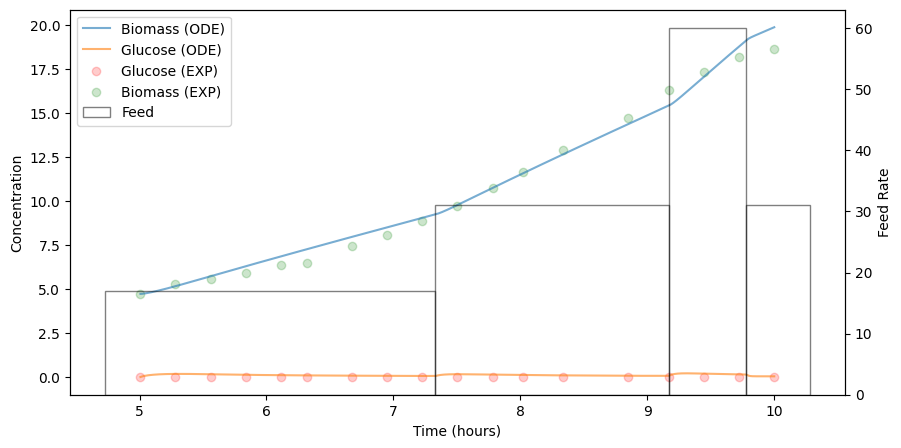

In [3]:
def get_fed_batch_data(filename: str, experiment: str):
    # Only FED-BATCH data
    full_df, feeds = get_data_and_feed(filename, experiment)
    full_df = full_df[full_df['Process'] == 'FB']
    feeds = feeds[feeds['Induction']==0]

    print(f'Dataset shape: {full_df.shape}')

    return full_df, feeds

full_df, feeds = get_fed_batch_data(FILENAME, EXPERIMENT)
full_df = fit_polynomial(full_df, degree=4, step=STEP, plot=False)
_ = simulate(full_df, feeds, mu_max=0.724, Ks=0.16, Yxs=0.66)

In [4]:
net, net_df = main(full_df=full_df, feeds=feeds, i=5, num_epochs=10000)

Training with 5 data points


Epoch 0 || Total Loss: 121981.1250, Loss Data: 36.2208, Loss ODE: 121918.1797, Loss IC: 26.7279
mu_max: 0.5005, Ks: 0.4995, Yxs: 0.4995
Epoch 250 || Total Loss: 21.8430, Loss Data: 6.4149, Loss ODE: 11.7386, Loss IC: 3.6896
mu_max: 0.4895, Ks: 0.4967, Yxs: 0.5060
Epoch 500 || Total Loss: 20.3509, Loss Data: 5.8532, Loss ODE: 11.2285, Loss IC: 3.2692
mu_max: 0.4709, Ks: 0.4967, Yxs: 0.5142
Epoch 750 || Total Loss: 18.2091, Loss Data: 5.1304, Loss ODE: 10.3453, Loss IC: 2.7334
mu_max: 0.4457, Ks: 0.4967, Yxs: 0.5239


KeyboardInterrupt: 